Start date,2023-01-31
End date,2023-06-26
Total months,7
,Backtest
Annual return,15.6%
Cumulative returns,8.8%
Annual volatility,10.6%
Sharpe ratio,1.42
Calmar ratio,3.25
Stability,0.43
Max drawdown,-4.8%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.81,2023-03-26,2023-04-27,2023-05-18,39
1,3.82,2023-02-14,2023-03-16,2023-03-23,28
2,1.60,2023-02-05,2023-02-07,2023-02-14,7
3,1.39,2023-06-15,2023-06-21,NaT,NaN
4,1.30,2023-05-30,2023-06-01,2023-06-07,7


Stress Events,mean,min,max
New Normal,0.06%,-2.30%,2.30%


Days: 147
0.00095 0.00878 1.722


Start date,2023-01-31
End date,2023-06-26
Total months,7
,Backtest
Annual return,25.9%
Cumulative returns,14.4%
Annual volatility,13.9%
Sharpe ratio,1.72
Calmar ratio,3.42
Stability,0.77
Max drawdown,-7.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.57,2023-04-17,2023-05-11,2023-06-13,42
1,3.18,2023-03-07,2023-03-14,2023-03-22,12
2,3.07,2023-03-26,2023-04-07,2023-04-12,13
3,2.99,2023-06-18,2023-06-26,NaT,NaN
4,1.74,2023-02-05,2023-02-22,2023-03-01,18


Stress Events,mean,min,max
New Normal,0.10%,-2.60%,2.60%


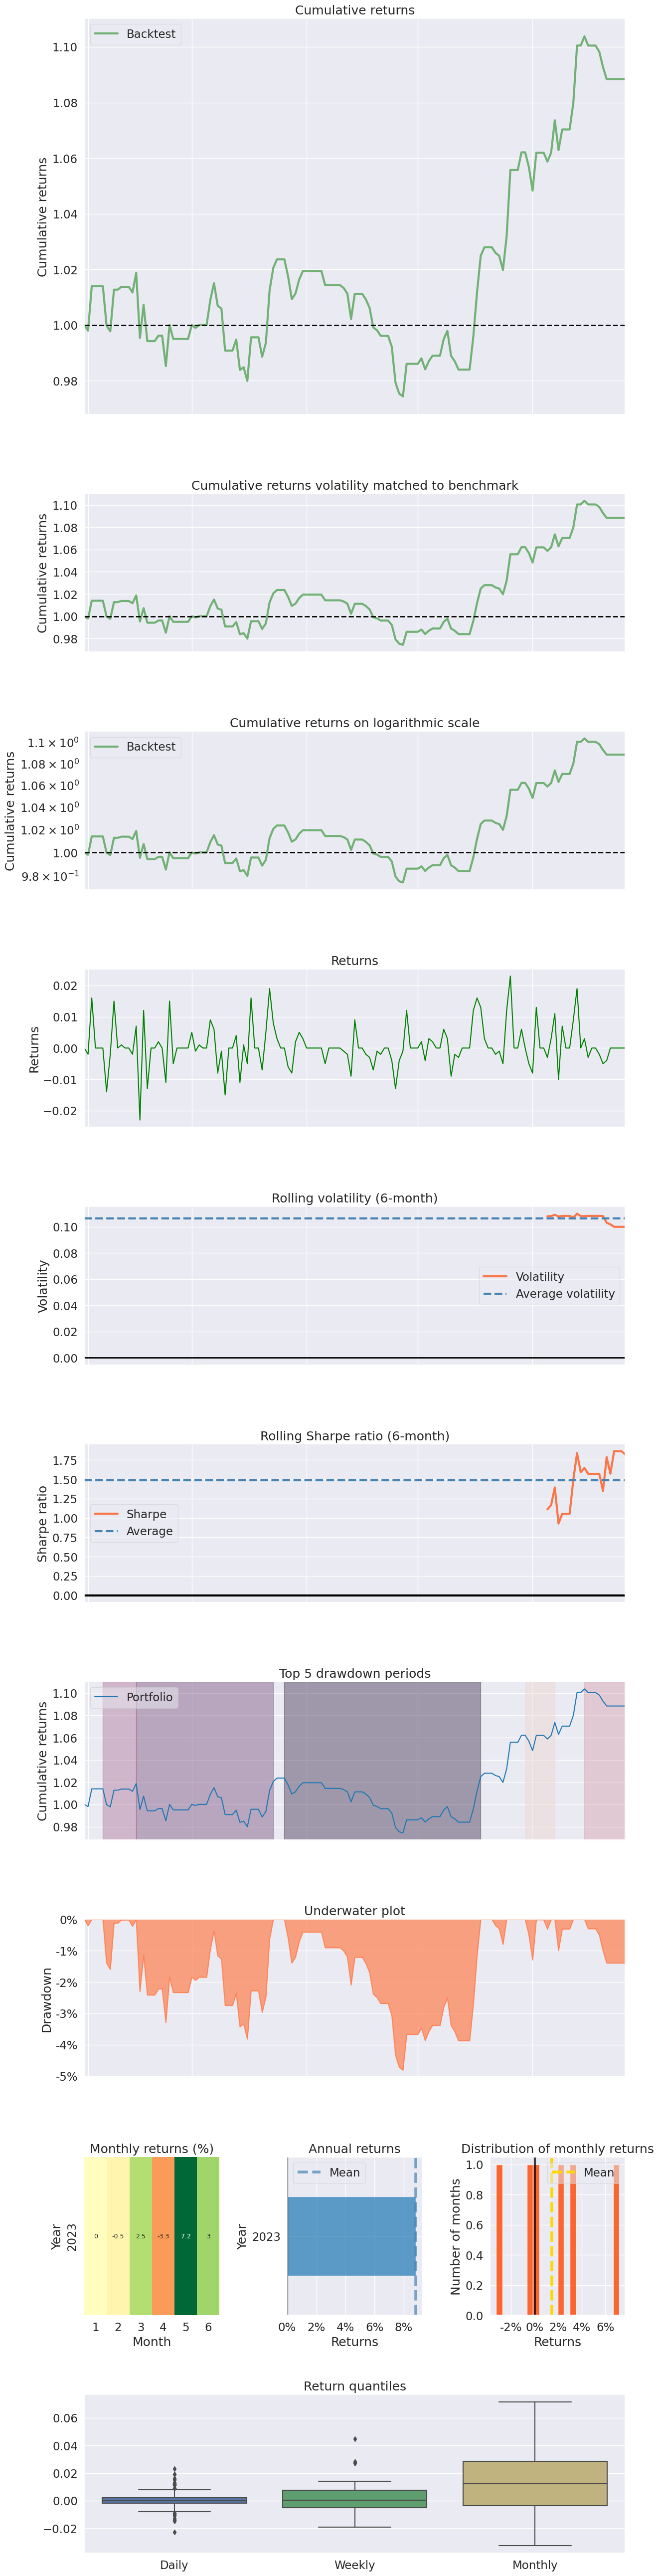

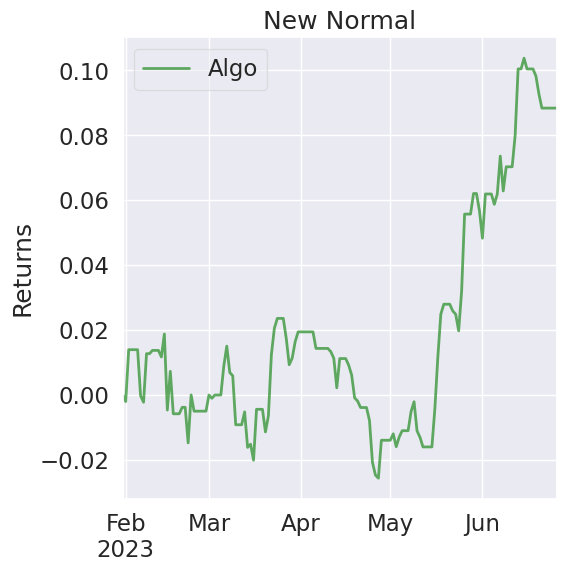

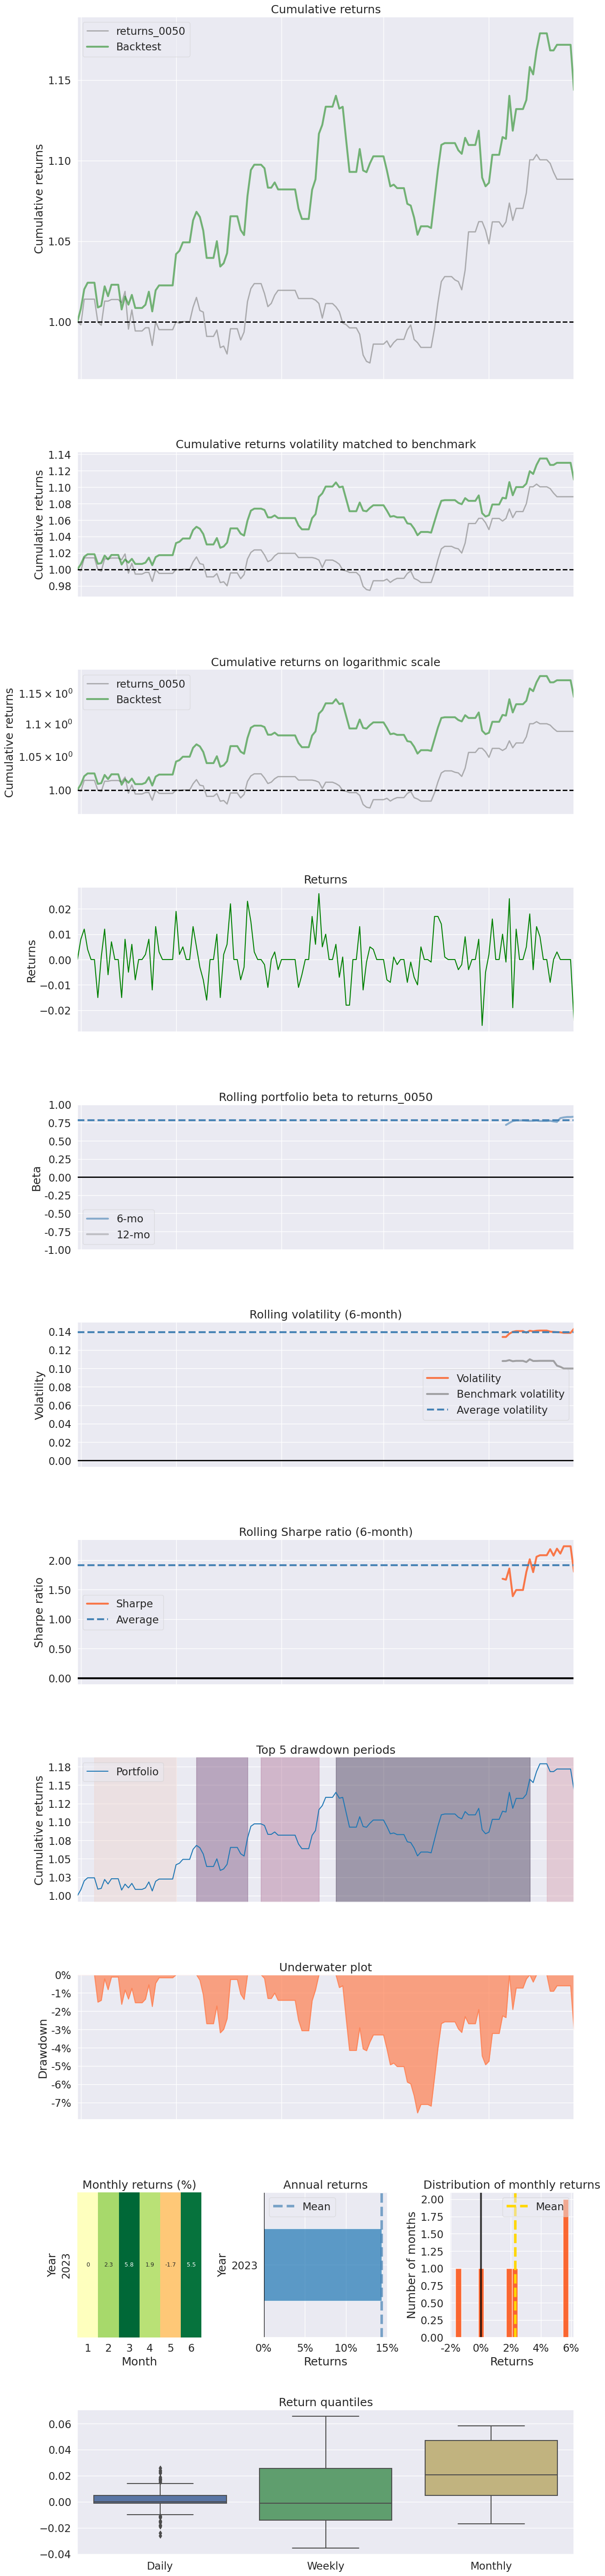

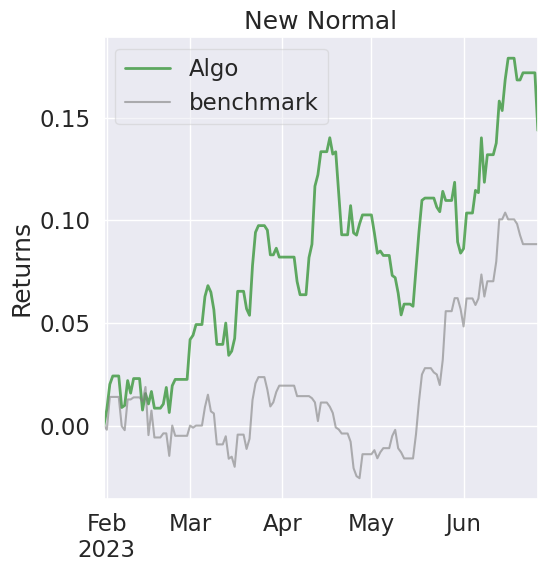

In [3]:
import backtrader as bt
import yfinance as yf
import pandas as pd
from datetime import datetime, timezone, timedelta
import pyfolio as pf
from typing import Tuple
import warnings
import time
import math
warnings.filterwarnings('ignore')

class CustomCommission(bt.CommInfoBase):
    # 證交稅跟手續費
    params = (
        ('stampduty', 0.003),
        ('commission', 0.001425),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_PERC),
        ('minCommission', 20),
        ('percabs', True),
    )

    def _getcommission(self, size, price, pseudoexec):
        fee = 0

        if size > 0:
            fee = max(size * price * self.p.commission, self.p.minCommission)
        elif size < 0:
            fee = max(abs(size) * price * self.p.commission, self.p.minCommission) + abs(size) * price * self.p.stampduty

        return int(fee)

class PopularTickerStrategy(bt.Strategy):
    def __init__(self) -> None:
        self.last_bar = len(self.datas[0].array) - 1
        self.is_buy = False
    
    # def notify_cashvalue(self, cash, value):
    #     print(f"Date: {self.data.datetime.date(0).strftime('%Y-%m-%d')}, Cash: {cash}, Value: {value}")

    def notify_order(self, order):
        if order.status in [order.Margin]:
            print("Margin")

        # if order.status in [order.Completed]:
        #     if order.isbuy():
        #         print(
        #             "BUY EXECUTED, Price: %.2f, Size: %.2f, Comm %.2f, Cost %.2f, Cash %.2f"
        #             % (
        #                 order.executed.price,
        #                 order.executed.size,
        #                 order.executed.comm,
        #                 order.executed.price * order.executed.size + order.executed.comm,
        #                 self.broker.getcash(),
        #             )
        #         )
        #     else:
        #         print(
        #             "SELL EXECUTED, Price: %.2f, Size: %.2f, Comm %.2f, Profit %.2f, Cash %.2f"
        #             % (
        #                 order.executed.price,
        #                 order.executed.size,
        #                 order.executed.comm,
        #                 order.executed.price * (-order.executed.size) - order.executed.comm,
        #                 self.broker.getcash(),
        #             )
        #         )

    def next(self) -> None:
        if ((self.position) and
            (len(self) == self.last_bar)):
            self.close()

    def next_open(self) -> None:
        if ((not self.position) and
            (not self.is_buy)):
            self.buy()
            self.sell(exectype = bt.Order.StopTrail, trailpercent = 0.1)
            self.is_buy = True

class ETFStrategy(bt.Strategy):
    def __init__(self) -> None:
        self.last_bar = len(self.datas[0].array) - 1
        self.is_buy = False
    
    # def notify_cashvalue(self, cash, value):
    #     print(f"Date: {self.data.datetime.date(0).strftime('%Y-%m-%d')}, Cash: {cash}, Value: {value}")

    def notify_order(self, order):
        if order.status in [order.Margin]:
            print("Margin")

        # if order.status in [order.Completed]:
        #     if order.isbuy():
        #         print(
        #             "BUY EXECUTED, Price: %.2f, Size: %.2f, Comm %.2f, Cost %.2f, Cash %.2f"
        #             % (
        #                 order.executed.price,
        #                 order.executed.size,
        #                 order.executed.comm,
        #                 order.executed.price * order.executed.size + order.executed.comm,
        #                 self.broker.getcash(),
        #             )
        #         )
        #     else:
        #         print(
        #             "SELL EXECUTED, Price: %.2f, Size: %.2f, Comm %.2f, Profit %.2f, Cash %.2f"
        #             % (
        #                 order.executed.price,
        #                 order.executed.size,
        #                 order.executed.comm,
        #                 order.executed.price * (-order.executed.size) - order.executed.comm,
        #                 self.broker.getcash(),
        #             )
        #         )

    def next(self) -> None:
        if ((not self.position) and
            (not self.is_buy)):
            self.buy()
            self.is_buy = True

        if ((self.position) and
            (len(self) == self.last_bar)):
            self.close()


class HandleBackTrader():
    def __init__(self) -> None:
        self.cerebro = None
        self.cash_unit = 300000
        self.CustomCommission = CustomCommission()

    def _init_interval_returns(self, start_date : str, end_date : str) -> pd.Series:
        index = []
        data = {}

        start_date = datetime.strptime(start_date, '%Y-%m-%d').replace(tzinfo = timezone.utc)
        end_date = datetime.strptime(end_date, '%Y-%m-%d').replace(tzinfo = timezone.utc)

        while start_date <= end_date:
            index.append(start_date)
            data[start_date] = 0.00

            start_date += timedelta(days = 1)
        
        return pd.Series(data, index = index, dtype = float)

    def _get_yahoo_finance_data(self, stock_num : str, start_date : str, type : str = "") -> pd.DataFrame:
        end_date = ""

        if type == "ETF":
            end_date = datetime.strftime(datetime.now(), '%Y-%m-%d')
        else:
            date = start_date.split("-")
            date[1] = int(date[1]) + 2

            if date[1] > 12:
                date[1] -= 12
                date[0] = int(date[0]) + 1

            end_date = f"{date[0]}-{str(date[1]).zfill(2)}-01"

        while True:
            try:
                result = yf.download(f"{stock_num}.TW", start = start_date, end = end_date, progress = False, show_errors = False)
                
                if result.empty:
                    result = yf.download(f"{stock_num}.TWO", start = start_date, end = end_date, progress = False, show_errors = False)
                break
            except:
                time.sleep(0.1)

        new_index = []

        for i in range(len(result.index)):
            new_index.append(datetime.strptime(result.index[i].strftime('%Y-%m-%d'), '%Y-%m-%d').replace(tzinfo = timezone.utc))

        result.index = new_index

        return result
    
    def _handle_ETF(self, stock_num : str, interval : str, cash : int) -> Tuple[pd.Series, int]:
        self.cerebro = bt.Cerebro(cheat_on_open = True)
        self.cerebro.addstrategy(ETFStrategy)

        self.cerebro.broker.setcash(cash)
        self.cerebro.broker.addcommissioninfo(self.CustomCommission)
        # calculate size with close, buy with open
        self.cerebro.addsizer(bt.sizers.PercentSizer, percents = 97, retint = True)

        data = self._get_yahoo_finance_data(stock_num, interval, "ETF")
        self.cerebro.adddata(bt.feeds.PandasData(dataname = data))
        self.cerebro.addanalyzer(bt.analyzers.PyFolio, _name = 'pyfolio')

        results = self.cerebro.run()
        pyfoliozer = results[0].analyzers.getbyname('pyfolio')
        returns, _, _, _ = pyfoliozer.get_pf_items()

        return returns, round(self.cerebro.broker.getvalue(), 2)
    
    def _handle_target(self, stock_list : list, interval : str, cash : int) -> Tuple[pd.Series, int]:
        unit = int(cash / len(stock_list))
        balance = cash - unit * len(stock_list)
        # print(f"unit: {unit}, balance: {balance}")
        average_returns = pd.Series(dtype = "float64")
            
        for stock in stock_list:
            self.cerebro = bt.Cerebro(cheat_on_open = True)
            self.cerebro.addstrategy(PopularTickerStrategy)
            self.cerebro.broker.setcash(unit)
            self.cerebro.broker.addcommissioninfo(self.CustomCommission)
            self.cerebro.addsizer(bt.sizers.PercentSizer, percents = 97, retint = True)

            data = self._get_yahoo_finance_data(stock, interval)

            self.cerebro.adddata(bt.feeds.PandasData(dataname = data))
            self.cerebro.addanalyzer(bt.analyzers.PyFolio, _name = 'pyfolio')

            results = self.cerebro.run()
            pyfoliozer = results[0].analyzers.getbyname('pyfolio')
            returns, _, _, _ = pyfoliozer.get_pf_items()

            if average_returns.empty:
                average_returns = returns
            else:
                average_returns = average_returns.add(returns)

            balance += self.cerebro.broker.getvalue()
        average_returns = average_returns.div(len(stock_list))

        return average_returns, round(balance, 2)
    
    def run(self) -> None:
        stocks = {
            "2023-01-31" : ["2330", "3008", "1707", "2303", "2408", "5288"],
            "2023-02-24" : ["5347", "2301", "2409", "3711", "4966", "2454", "8454"],
            "2023-03-31" : ["2395", "6488", "2723", "2327", "4551", "2317", "2634", "1590"],
            "2023-04-28" : ["2637", "1590", "2327", "2330", "2408"],
            "2023-05-31" : ["2376", "8069", "2882", "2049", "1476", "1504", "8299", "3661", "8081"]
        }
        returns_ETF_result = self._init_interval_returns("2023-01-31", "2023-06-26")
        returns_target_result = self._init_interval_returns("2023-01-31", "2023-06-26")

        ETF_cash = self.cash_unit
        target_cash = self.cash_unit

        # print("ETF")
        ETF = "0050"
        returns_ETF, ETF_cash = self._handle_ETF(ETF, "2023-01-31", ETF_cash)

        for i in range(len(returns_ETF)):
                returns_ETF_result[returns_ETF.index[i]] = round((1 + returns_ETF_result[returns_ETF.index[i]]) * (1 + returns_ETF[i]) - 1, 3)
        # print(ETF_cash)

        pf.create_full_tear_sheet(returns = returns_ETF_result)

        for interval in stocks:
            # print("target")
            returns_target, target_cash = self._handle_target(stocks[interval], interval, target_cash)

            for i in range(len(returns_target)):
                returns_target_result[returns_target.index[i]] = round((1 + returns_target_result[returns_target.index[i]]) * (1 + returns_target[i]) - 1, 3)
            # print("====="*10)

            # print(target_cash)

        returns_ETF_result.rename(f"returns_{ETF}", inplace = True)
        print(f"Days: {len(returns_target_result)}")
        print(round(returns_target_result.mean(), 5), round(returns_target_result.std(), 5), round(math.sqrt(252) * returns_target_result.mean() / returns_target_result.std(), 3))

        pf.create_full_tear_sheet(returns = returns_target_result, benchmark_rets = returns_ETF_result)

if __name__ == "__main__":
    handle_back_trader = HandleBackTrader()
    handle_back_trader.run()